In [1]:
!conda env list

# conda environments:
#
base                     /home/andres/miniconda3
acdc                  *  /home/andres/miniconda3/envs/acdc



In [8]:
MODEL_NAME = "andres-vs/bert-base-uncased-finetuned_Att-Noneg-depth0"
NEXAMPLES = 2
THRESHOLD = 0.1

<h1>ACDC Main Demo</h1>

<p>This notebook (which doubles as a script) shows several use cases of ACDC</p>

<p>The codebase is built on top of https://github.com/neelnanda-io/TransformerLens (source version)</p>

<h3>Setup:</h3>
<p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    import subprocess # to install graphviz dependencies
    command = ['apt-get', 'install', 'graphviz-dev']
    subprocess.run(command, check=True)
    

    import os # make images folder
    os.mkdir("ims/")

    from IPython import get_ipython
    ipython = get_ipython()

    ipython.run_line_magic( # install ACDC
        "pip",
        "install git+https://github.com/andres-vs/Automatic-Circuit-Discovery.git@7b1af32108f8896bef193ac4ae8fe7bf73bf03d5",
    )

except Exception as e:
    print(e)
    IN_COLAB = False
    print("Running outside of colab")

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    import os # make images folder
    if not os.path.exists("ims/"):
        os.mkdir("ims/")

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        print("Running as a notebook")
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore
    else:
        print("Running as a script")

No module named 'google.colab'
Running outside of colab
Running as a notebook


In [ ]:
!pip uninstall transformer-lens

In [ ]:
ipython.run_line_magic( # install custom transformerlens library
        "pip",
        "install git+https://github.com/andres-vs/TransformerLens.git@1a46c77aefc06099b432108c95e34d1ffcf60a50",
    )

In [3]:
import sys
import os

# Add the directory containing your module to the Python path (sys.path)
sys.path.append(os.path.abspath("/mnt/c/Users/andre/Documents/School/Hoger/Masterproef/Code/TransformerLens"))

# Now you can import your module
# import transformer_lens


In [4]:
print(sys.path)

['/home/andres/miniconda3/envs/acdc/lib/python310.zip', '/home/andres/miniconda3/envs/acdc/lib/python3.10', '/home/andres/miniconda3/envs/acdc/lib/python3.10/lib-dynload', '', '/home/andres/.local/lib/python3.10/site-packages', '/home/andres/miniconda3/envs/acdc/lib/python3.10/site-packages', '/mnt/c/Users/andre/Documents/School/Hoger/Masterproef/Code/Automatic-Circuit-Discovery', '/mnt/c/Users/andre/Documents/School/Hoger/Masterproef/Code/TransformerLens']


<h2>Imports etc</h2>

In [5]:
import wandb
import IPython
from IPython.display import Image, display
import torch
import gc
from tqdm import tqdm
import networkx as nx
import os
import torch
import huggingface_hub
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from tqdm import tqdm
import yaml
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens.HookedTransformer import (
    HookedTransformer,
)
try:
    from acdc.tracr_task.utils import (
        get_all_tracr_things,
        get_tracr_model_input_and_tl_model,
    )
except Exception as e:
    print(f"Could not import `tracr` because {e}; the rest of the file should work but you cannot use the tracr tasks")
from acdc.docstring.utils import get_all_docstring_things
from acdc.acdc_utils import (
    make_nd_dict,
    reset_network,
    shuffle_tensor,
    cleanup,
    ct,
    TorchIndex,
    Edge,
    EdgeType,
)  # these introduce several important classes !!!

from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.TLACDCExperiment import TLACDCExperiment

from acdc.acdc_utils import (
    kl_divergence,
)
from acdc.ioi.utils import (
    get_all_ioi_things,
    get_gpt2_small,
)
from acdc.induction.utils import (
    get_all_induction_things,
    get_validation_data,
    get_good_induction_candidates,
    get_mask_repeat_candidates,
)
from acdc.greaterthan.utils import get_all_greaterthan_things
from acdc.text_entailment.utils import get_all_text_entailment_things
from acdc.acdc_graphics import (
    build_colorscheme,
    show,
)
import argparse

torch.autograd.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>ACDC Experiment Setup</h2>
<p>We use a `parser to set all the options for the ACDC experiment.
This is still usable in notebooks! We can pass a string to the parser, see below.
We'll reproduce </p>

In [9]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")

task_choices = ['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan', 'text-entailment']
parser.add_argument('--task', type=str, required=True, choices=task_choices, help=f'Choose a task from the available options: {task_choices}')
parser.add_argument('--threshold', type=float, required=True, help='Value for THRESHOLD')
parser.add_argument('--first-cache-cpu', type=str, required=False, default="True", help='Value for FIRST_CACHE_CPU (the old name for the `online_cache`)')
parser.add_argument('--second-cache-cpu', type=str, required=False, default="True", help='Value for SECOND_CACHE_CPU (the old name for the `corrupted_cache`)')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--using-wandb', action='store_true', help='Use wandb')
parser.add_argument('--wandb-entity-name', type=str, required=False, default="default", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group-name', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project-name', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--indices-mode', type=str, default="normal")
parser.add_argument('--names-mode', type=str, default="normal")
parser.add_argument('--device', type=str, default="cuda")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument("--max-num-epochs",type=int, default=100_000)
parser.add_argument('--single-step', action='store_true', help='Use single step, mostly for testing')
parser.add_argument("--abs-value-threshold", action='store_true', help='Use the absolute value of the result to check threshold')

if ipython is not None:
    # We are in a notebook
    # you can put the command you would like to run as the ... in r"""..."""
    args = parser.parse_args(
        [line.strip() for line in rf"""--task=text-entailment\
--threshold={THRESHOLD}\
--indices-mode=reverse\
--first-cache-cpu=True\
--second-cache-cpu=True\
--max-num-epochs=100000\
--device=cuda""".split("\\\n")]
    )




else:
    # read from command line
    args = parser.parse_args()

# Process args

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

TASK = args.task
if args.first_cache_cpu is None: # manage default
    ONLINE_CACHE_CPU = True
elif args.first_cache_cpu.lower() == "false":
    ONLINE_CACHE_CPU = False
elif args.first_cache_cpu.lower() == "true":
    ONLINE_CACHE_CPU = True
else:
    raise ValueError(f"first_cache_cpu must be either True or False, got {args.first_cache_cpu}")
if args.second_cache_cpu is None:
    CORRUPTED_CACHE_CPU = True
elif args.second_cache_cpu.lower() == "false":
    CORRUPTED_CACHE_CPU = False
elif args.second_cache_cpu.lower() == "true":
    CORRUPTED_CACHE_CPU = True
else:
    raise ValueError(f"second_cache_cpu must be either True or False, got {args.second_cache_cpu}")
THRESHOLD = args.threshold  # only used if >= 0.0
ZERO_ABLATION = True if args.zero_ablation else False
USING_WANDB = True if args.using_wandb else False
WANDB_ENTITY_NAME = args.wandb_entity_name
WANDB_PROJECT_NAME = args.wandb_project_name
WANDB_RUN_NAME = args.wandb_run_name
print(WANDB_RUN_NAME)
WANDB_GROUP_NAME = args.wandb_group_name
INDICES_MODE = args.indices_mode
NAMES_MODE = args.names_mode
DEVICE = args.device
RESET_NETWORK = args.reset_network
SINGLE_STEP = True if args.single_step else False

None


<h2>Setup Task</h2>

In [10]:

second_metric = None  # some tasks only have one metric
use_pos_embed = TASK.startswith("tracr")

if TASK == "ioi":
    num_examples = 100
    things = get_all_ioi_things(
        num_examples=num_examples, device=DEVICE, metric_name=args.metric
    )
elif TASK == "tracr-reverse":
    num_examples = 6
    things = get_all_tracr_things(
        task="reverse",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "tracr-proportion":
    num_examples = 50
    things = get_all_tracr_things(
        task="proportion",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "induction":
    num_examples = 10
    seq_len = 300
    things = get_all_induction_things(
        num_examples=num_examples, seq_len=seq_len, device=DEVICE, metric=args.metric
    )
elif TASK == "docstring":
    num_examples = 50
    seq_len = 41
    things = get_all_docstring_things(
        num_examples=num_examples,
        seq_len=seq_len,
        device=DEVICE,
        metric_name=args.metric,
        correct_incorrect_wandb=True,
    )
elif TASK == "greaterthan":
    num_examples = 10
    things = get_all_greaterthan_things(
        num_examples=num_examples, metric_name=args.metric, device=DEVICE
    )
elif TASK == "text-entailment":
    num_examples = NEXAMPLES
    model_name = MODEL_NAME
    things = get_all_text_entailment_things(
        model_name=model_name, num_examples=num_examples, metric_name=args.metric, device=DEVICE
    )
else:
    raise ValueError(f"Unknown task {TASK}")

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  cuda
Loaded pretrained model andres-vs/bert-base-uncased-finetuned_Att-Noneg-depth0 into HookedTransformer
Moving model to device:  cuda
{'n_layers': 12, 'd_model': 768, 'n_ctx': 512, 'd_head': 64, 'model_name': 'bert-base-uncased-finetuned_Att-Noneg-depth0', 'n_heads': 12, 'd_mlp': 3072, 'act_fn': 'gelu', 'd_vocab': 30522, 'eps': 1e-12, 'use_attn_result': True, 'use_attn_scale': True, 'use_split_qkv_input': True, 'use_hook_mlp_in': False, 'use_attn_in': False, 'use_local_attn': False, 'original_architecture': 'BertForSequenceClassification', 'from_checkpoint': False, 'checkpoint_index': None, 'checkpoint_label_type': None, 'checkpoint_value': None, 'tokenizer_name': 'andres-vs/bert-base-uncased-finetuned_Att-Noneg-depth0', 'window_size': None, 'attn_types': None, 'init_mode': 'gpt2', 'normalization_type': 'LN', 'device': 'cuda', 'n_devices': 1, 'attention_dir': 'bidirectional', 'attn_only': False, 'seed': None, 'initializer_range': 0.02886751345948129, 'init_w

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]

base_model_logits tensor([[-4.5032,  4.6794],
        [ 4.4258, -4.3345],
        [-3.1264,  3.1806],
        [-3.7186,  3.5201]], device='cuda:0')
base_model_logprobs tensor([[-9.1827e+00, -1.0275e-04],
        [-1.5687e-04, -8.7605e+00],
        [-6.3089e+00, -1.8218e-03],
        [-7.2394e+00, -7.1798e-04]], device='cuda:0')
torch.Size([2, 2]) torch.Size([2, 2])


In [8]:
gc.collect()

0

In [ ]:
torch.cuda.empty_cache()

<p> Let's define the four most important objects for ACDC experiments:

In [11]:
validation_metric = things.validation_metric # metric we use (e.g KL divergence)
toks_int_values = things.validation_data # clean data x_i
toks_int_values_other = things.validation_patch_data # corrupted data x_i'
tl_model = things.tl_model # transformerlens model

if RESET_NETWORK:
    reset_network(TASK, DEVICE, tl_model)

In [12]:
print("Total size of toks_int_values in bytes:", toks_int_values.element_size() * toks_int_values.numel())
print("Total size of toks_int_values_other in bytes:", toks_int_values_other.element_size() * toks_int_values_other.numel())
print(toks_int_values.size(), toks_int_values_other.size())

Total size of toks_int_values in bytes: 2400
Total size of toks_int_values_other in bytes: 2400
torch.Size([2, 150]) torch.Size([2, 150])


In [ ]:
wandb.init(project='acdc', name="test")

<h2>Setup ACDC Experiment</h2>

In [ ]:
# Make notes for potential wandb run
try:
    with open(__file__, "r") as f:
        notes = f.read()
except:
    notes = "No notes generated, expected when running in an .ipynb file"

tl_model.reset_hooks()

# Save some mem
gc.collect()
torch.cuda.empty_cache()

# Setup wandb if needed
if WANDB_RUN_NAME is None or IPython.get_ipython() is not None:
    WANDB_RUN_NAME = f"{ct()}{'_randomindices' if INDICES_MODE=='random' else ''}_{THRESHOLD}{'_zero' if ZERO_ABLATION else ''}"
else:
    assert WANDB_RUN_NAME is not None, "I want named runs, always"

tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=tl_model,
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=WANDB_RUN_NAME,
    wandb_group_name=WANDB_GROUP_NAME,
    wandb_notes=notes,
    wandb_dir=args.wandb_dir,
    wandb_mode=args.wandb_mode,
    wandb_config=args,
    zero_ablation=ZERO_ABLATION,
    abs_value_threshold=args.abs_value_threshold,
    ds=toks_int_values,
    ref_ds=toks_int_values_other,
    metric=validation_metric,
    second_metric=second_metric,
    verbose=False,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    corrupted_cache_cpu=CORRUPTED_CACHE_CPU,
    hook_verbose=False,
    online_cache_cpu=ONLINE_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=use_pos_embed,
    add_receiver_hooks=False,
    remove_redundant=True,
    show_full_index=use_pos_embed,
)

self.current_node=TLACDCInterpNode(blocks.11.hook_resid_post, [:])
Mem before corruption 451395584
Mem after enable caching 451395584


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Mem after forward pass batched 0 1250405888


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]

Mem after copying activations 0 1250405888
Corrupted cache batched shape torch.Size([2, 150, 768])
Mem after forward pass 1250405376
Mem after corrupted to cpu 1250405376


Mem after corruption 451395584
Mem after hooks 451395584


<h2>Run steps of ACDC: iterate over a NODE in the model's computational graph</h2>
<p>WARNING! This will take a few minutes to run, but there should be rolling nice pictures too : )</p>

We moved to  blocks.11.hook_mlp_out[:]


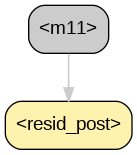

0 --------------------------------------------------
32767
We moved to  blocks.11.hook_mlp_in[:]


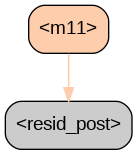

1 --------------------------------------------------
32767
We moved to  blocks.11.attn.hook_result[:, :, 11]
But it's bad
We moved to  blocks.11.attn.hook_result[:, :, 10]
But it's bad
We moved to  blocks.11.attn.hook_result[:, :, 9]
But it's bad
We moved to  blocks.11.attn.hook_result[:, :, 8]


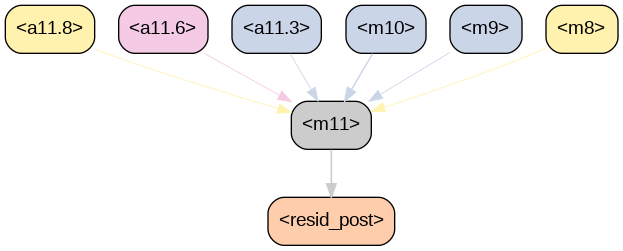

2 --------------------------------------------------
32617
We moved to  blocks.11.attn.hook_result[:, :, 7]
But it's bad
We moved to  blocks.11.attn.hook_result[:, :, 6]


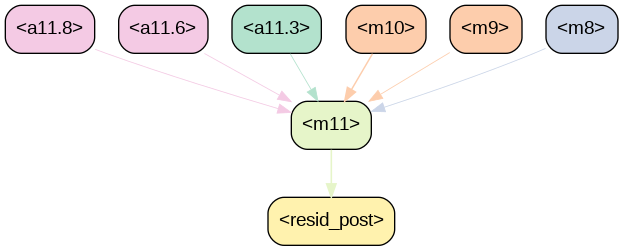

3 --------------------------------------------------
32617
We moved to  blocks.11.attn.hook_result[:, :, 5]
But it's bad
We moved to  blocks.11.attn.hook_result[:, :, 4]
But it's bad
We moved to  blocks.11.attn.hook_result[:, :, 3]


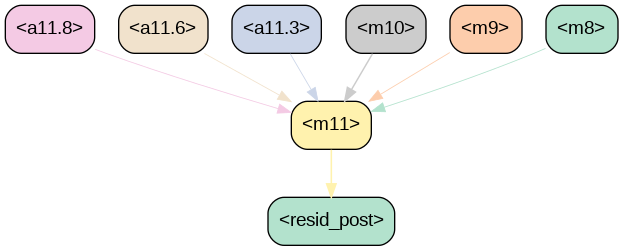

4 --------------------------------------------------
32617
We moved to  blocks.11.attn.hook_result[:, :, 2]
But it's bad
We moved to  blocks.11.attn.hook_result[:, :, 1]
But it's bad
We moved to  blocks.11.attn.hook_result[:, :, 0]
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 11]
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 10]
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 9]
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 8]


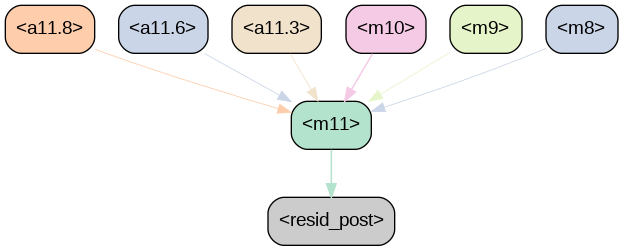

5 --------------------------------------------------
32614
We moved to  blocks.11.attn.hook_v[:, :, 7]
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 6]


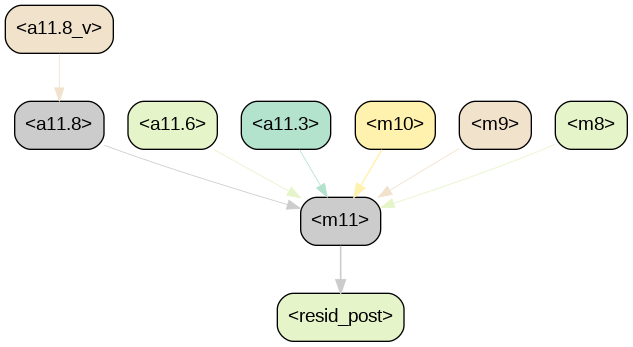

6 --------------------------------------------------
32613
We moved to  blocks.11.attn.hook_v[:, :, 5]
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 4]
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 3]


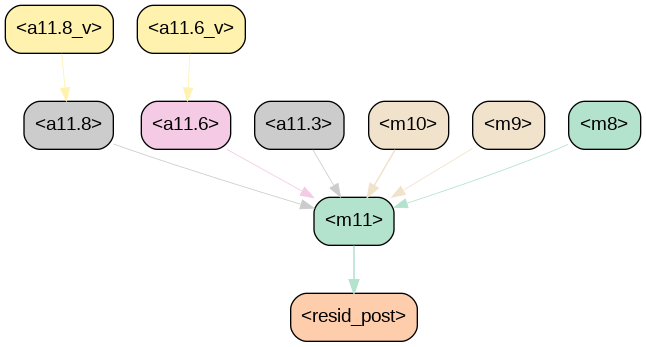

7 --------------------------------------------------
32611
We moved to  blocks.11.attn.hook_v[:, :, 2]
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 1]
But it's bad
We moved to  blocks.11.attn.hook_v[:, :, 0]
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 11]
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 10]
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 9]
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 8]


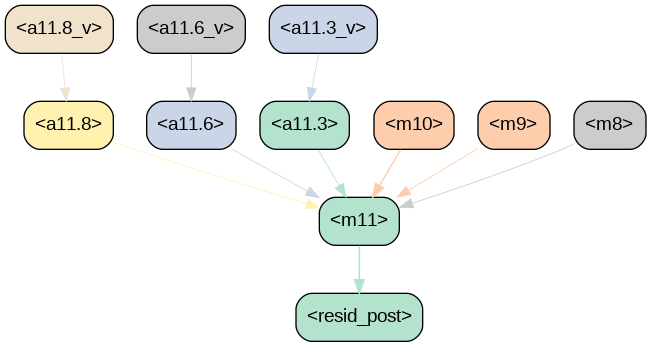

8 --------------------------------------------------
32605
We moved to  blocks.11.attn.hook_k[:, :, 7]
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 6]


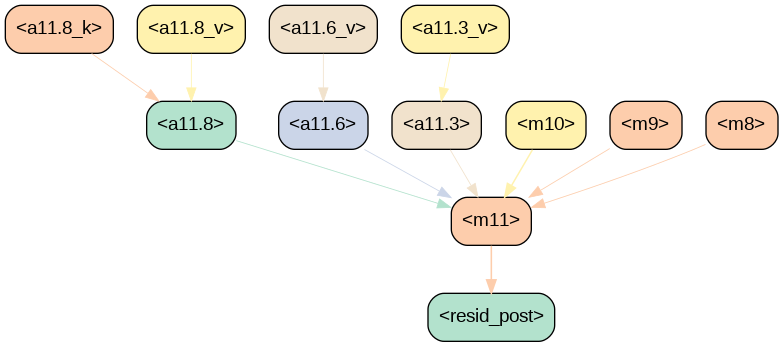

9 --------------------------------------------------
32604
We moved to  blocks.11.attn.hook_k[:, :, 5]
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 4]
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 3]


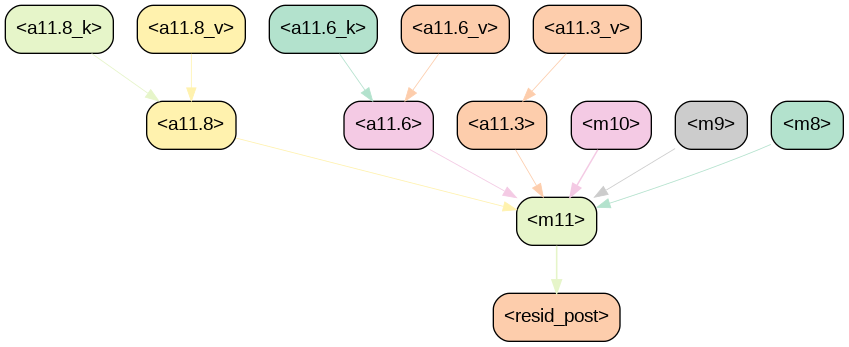

10 --------------------------------------------------
32602
We moved to  blocks.11.attn.hook_k[:, :, 2]
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 1]
But it's bad
We moved to  blocks.11.attn.hook_k[:, :, 0]
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 11]
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 10]
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 9]
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 8]


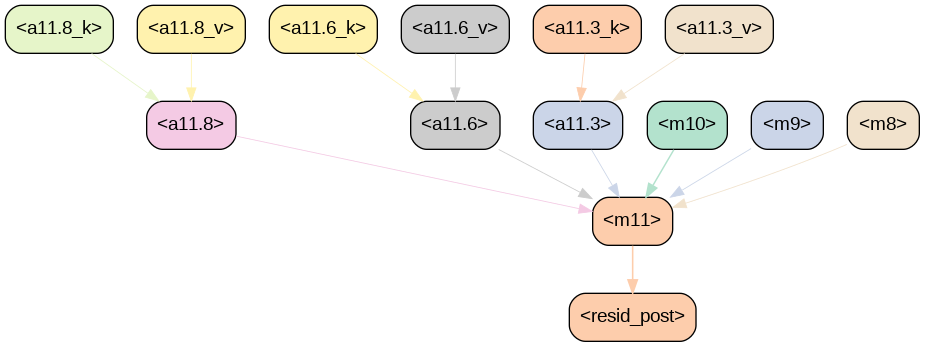

11 --------------------------------------------------
32596
We moved to  blocks.11.attn.hook_q[:, :, 7]
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 6]


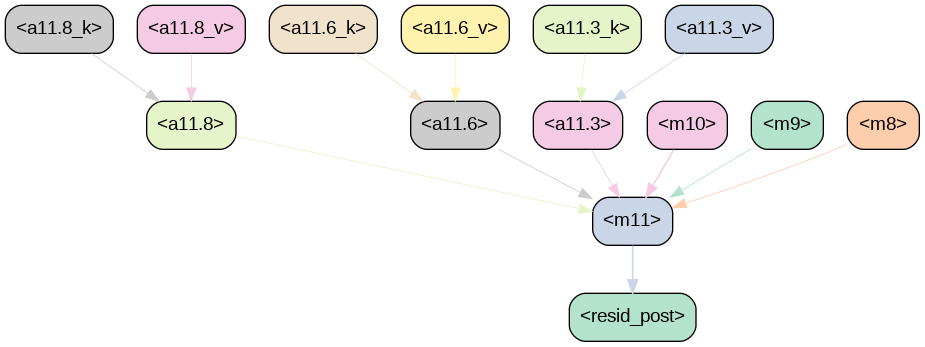

12 --------------------------------------------------
32594
We moved to  blocks.11.attn.hook_q[:, :, 5]
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 4]
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 3]


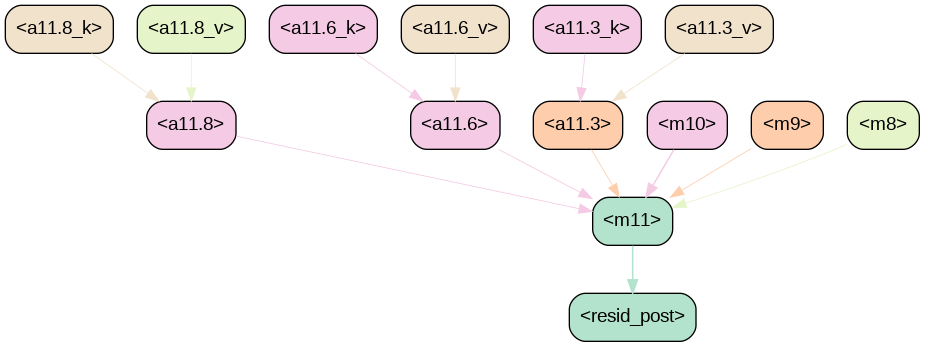

13 --------------------------------------------------
32591
We moved to  blocks.11.attn.hook_q[:, :, 2]
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 1]
But it's bad
We moved to  blocks.11.attn.hook_q[:, :, 0]
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 11]
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 10]
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 9]
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 8]


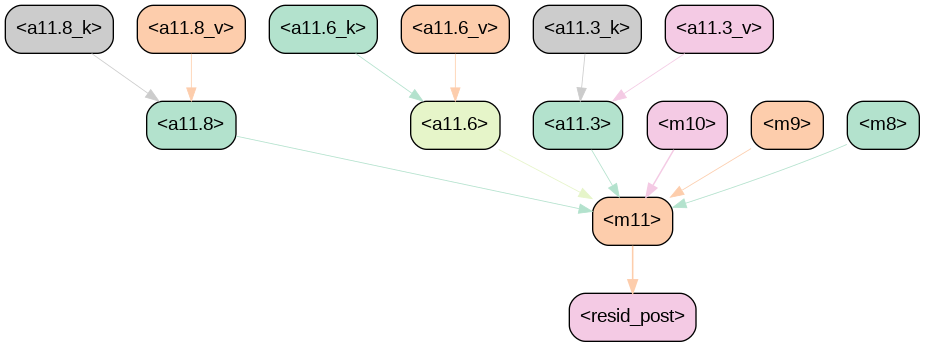

14 --------------------------------------------------
32155
We moved to  blocks.11.hook_v_input[:, :, 7]
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 6]


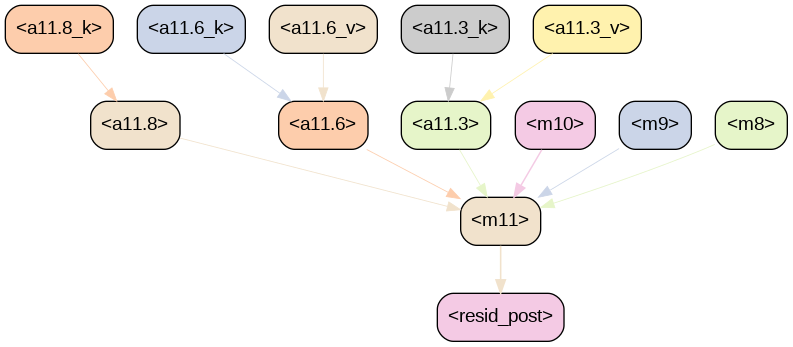

15 --------------------------------------------------
31866
We moved to  blocks.11.hook_v_input[:, :, 5]
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 4]
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 3]


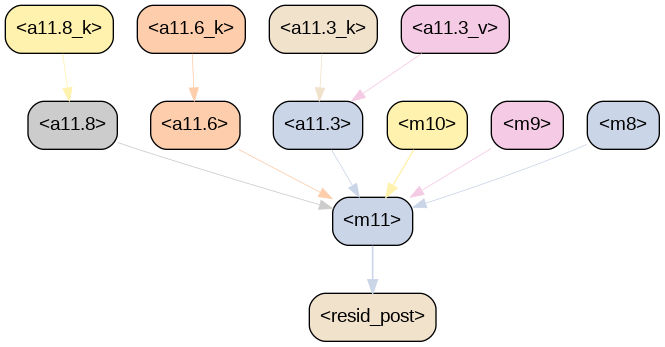

16 --------------------------------------------------
31433
We moved to  blocks.11.hook_v_input[:, :, 2]
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 1]
But it's bad
We moved to  blocks.11.hook_v_input[:, :, 0]
But it's bad
We moved to  blocks.11.hook_k_input[:, :, 11]
But it's bad
We moved to  blocks.11.hook_k_input[:, :, 10]
But it's bad
We moved to  blocks.11.hook_k_input[:, :, 9]
But it's bad
We moved to  blocks.11.hook_k_input[:, :, 8]


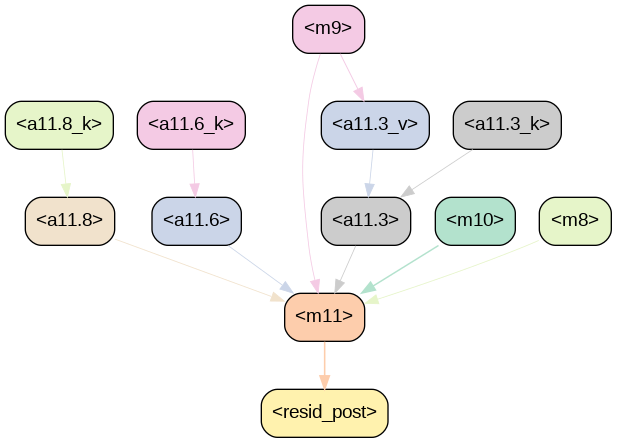

17 --------------------------------------------------
30426
We moved to  blocks.11.hook_k_input[:, :, 7]
But it's bad
We moved to  blocks.11.hook_k_input[:, :, 6]


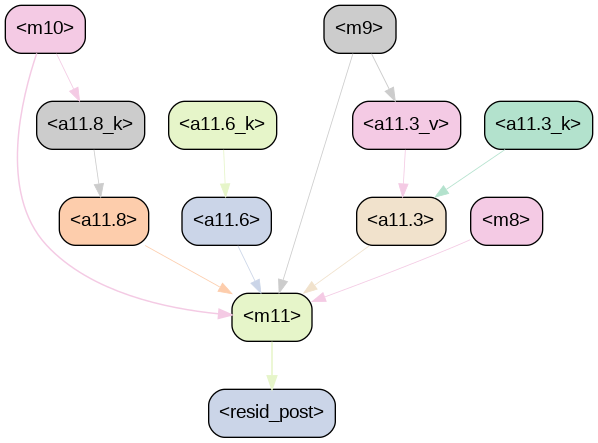

18 --------------------------------------------------
30139
We moved to  blocks.11.hook_k_input[:, :, 5]
But it's bad
We moved to  blocks.11.hook_k_input[:, :, 4]
But it's bad
We moved to  blocks.11.hook_k_input[:, :, 3]


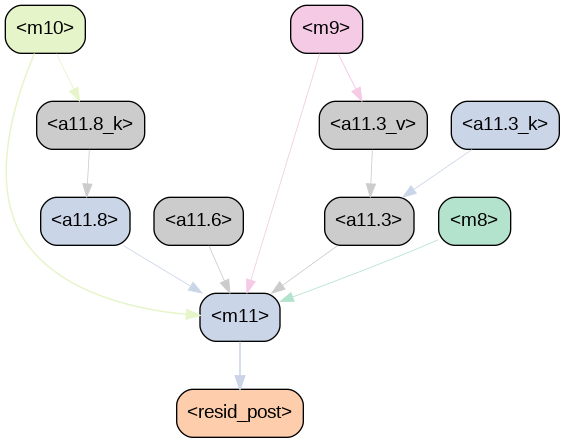

19 --------------------------------------------------
29706
We moved to  blocks.11.hook_k_input[:, :, 2]
But it's bad
We moved to  blocks.11.hook_k_input[:, :, 1]
But it's bad
We moved to  blocks.11.hook_k_input[:, :, 0]
But it's bad
We moved to  blocks.11.hook_q_input[:, :, 11]
But it's bad
We moved to  blocks.11.hook_q_input[:, :, 10]
But it's bad
We moved to  blocks.11.hook_q_input[:, :, 9]
But it's bad
We moved to  blocks.11.hook_q_input[:, :, 8]
But it's bad
We moved to  blocks.11.hook_q_input[:, :, 7]
But it's bad
We moved to  blocks.11.hook_q_input[:, :, 6]
But it's bad
We moved to  blocks.11.hook_q_input[:, :, 5]
But it's bad
We moved to  blocks.11.hook_q_input[:, :, 4]
But it's bad
We moved to  blocks.11.hook_q_input[:, :, 3]
But it's bad
We moved to  blocks.11.hook_q_input[:, :, 2]
But it's bad
We moved to  blocks.11.hook_q_input[:, :, 1]
But it's bad
We moved to  blocks.11.hook_q_input[:, :, 0]
But it's bad
We moved to  blocks.10.hook_mlp_out[:]


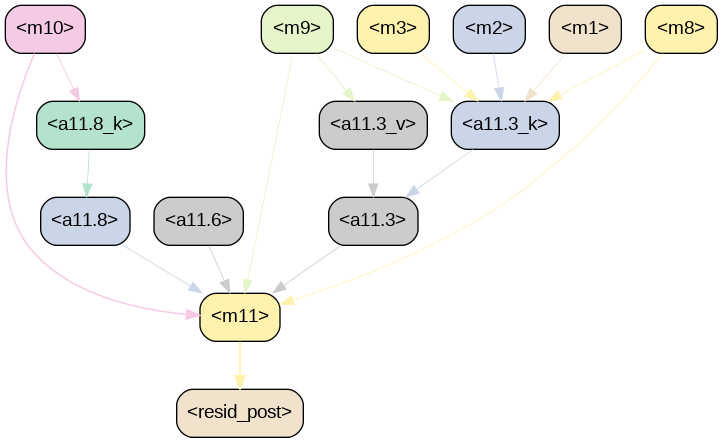

20 --------------------------------------------------
27407
We moved to  blocks.10.hook_mlp_in[:]


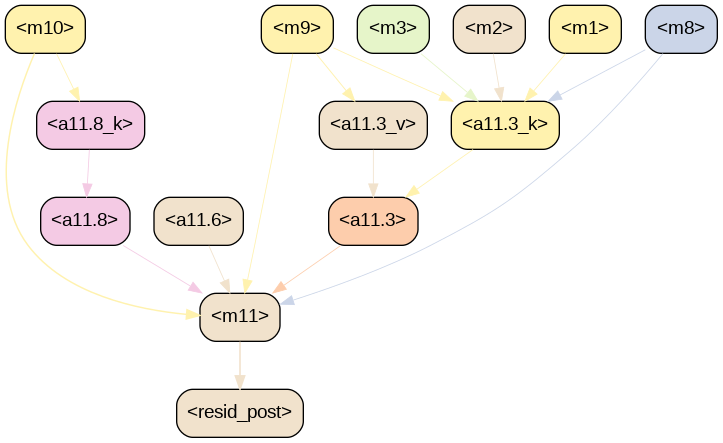

21 --------------------------------------------------
27407


In [ ]:
for i in range(args.max_num_epochs):
    exp.step(testing=False)

    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=False,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))

    print(i, "-" * 50)
    print(exp.count_no_edges())

    if i == 0:
        exp.save_edges("edges.pkl")

    if exp.current_node is None or SINGLE_STEP:
        break

exp.save_edges("another_final_edges.pkl")

if USING_WANDB:
    edges_fname = f"edges.pth"
    exp.save_edges(edges_fname)
    artifact = wandb.Artifact(edges_fname, type="dataset")
    artifact.add_file(edges_fname)
    wandb.log_artifact(artifact)
    os.remove(edges_fname)
    wandb.finish()

In [ ]:
wandb.finish()

cur_metric,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
experiment.cur_metric,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
num_edges,█████████████████████████████████▇▆▅▃▃▁▁
num_edges_total,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
cur_metric,0.0
experiment.cur_metric,0.0
num_edges,27247
num_edges_total,32766


<h2>Save the final subgraph of the model</h2>
<p>There are more than `exp.count_no_edges()` here because we include some "placeholder" edges needed to make ACDC work that don't actually matter</p>
<p>Also note that the final image has more than 12 edges, because the edges from a0.0_q and a0.0_k are not connected to the input</p>
<p>We recover minimal induction machinery! `embed -> a0.0_v -> a1.6k`</p>

In [ ]:
exp.save_subgraph(
    return_it=True,
)

OrderedDict([(('blocks.1.hook_resid_post',
               (None,),
               'blocks.1.attn.hook_result',
               (None, None, 6)),
              True),
             (('blocks.1.hook_resid_post',
               (None,),
               'blocks.0.hook_resid_pre',
               (None,)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_q',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_k',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_v',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_q',
               (None, None, 6),
               'blocks.1.hook_q_input',
               (None, None, 6)),
              True),
        